#Práctica 2 - Clasificación de Imágenes

Integrantes del equipo:

-Álvaro López Cruz -> bo0121

-Gonzalo Romero Sanchez -> bo0322

Primero importaremos las librerías que vamos a utilizar.

In [ ]:
import pandas as pd
import numpy as np
import zipfile as zip
import requests
import os
from skimage import io
from skimage.color import rgb2gray
import random
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from six import StringIO  
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
from skimage import filters
from skimage import exposure
from sklearn import preprocessing
from sklearn.metrics import plot_confusion_matrix
from skimage import transform
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import GridSearchCV
import cv2

Establecemos la aletoriedad de numpy en el valor 1337 para obtener valores coherentes.

In [ ]:
np.random.seed(1337)

##Preprocesamiento

Utilizamos la libreria 'request' para descargar el contenido de la url donde hemos subido los archivos comprimidos, y utilizamos la librería 'zipfile' para descromprimirlo una vez descargado.

Para ello, definimos las dos funciones siguientes, una para crear los directorios donde descomprimiremos los archivos .zip, y otra para guardar las imágenes en sus arrays correspondientes para poder trabajar con ellas.

In [ ]:
def createFolder(directory_path):
  try:
      os.mkdir(directory_path)
  except OSError:
      print ("Creación del directorio %s fallida" % directory_path)
  else:
      print ("Creado el directorio %s con éxito" % directory_path)

In [ ]:
def extractImages(url,directory_path,dataset_path,zipfile_path):
  with open(zipfile_path, 'wb') as f:
      f.write(r.content)
  z = zip.ZipFile(directory_path)
  z.extractall(dataset_path)

Primero obtenemos las imágenes del conjunto de datos de test:

In [ ]:
test_zipfile_path= '/content/testzip/test_zipfile'
test_directory_path = '/content/testzip'
test_dataset_path = '/content/test_dataset'
test_url = 'https://dl.dropboxusercontent.com/s/v18b6s7jmtdbzgw/test.zip?dl=0'
r = requests.get(test_url)
createFolder(test_directory_path)
extractImages(test_url,test_zipfile_path,test_dataset_path,test_zipfile_path)

Creación del directorio /content/testzip fallida


Ahora hacemos lo mismo para las de entrenamiento:

In [ ]:
train_zipfile_path = '/content/trainzip/train_zipfile'
train_directory_path = '/content/trainzip'
train_dataset_path = '/content/train_dataset'
train_url = 'https://dl.dropboxusercontent.com/s/ggt3l67wl87oiff/train.zip?dl=0'
r = requests.get(train_url)
createFolder(train_directory_path)
extractImages(train_url,train_zipfile_path,train_dataset_path,train_zipfile_path)

Creación del directorio /content/trainzip fallida


Probamos a dibujar dos imágenes aleatorias para ver si hemos descargado las imágenes con éxito.

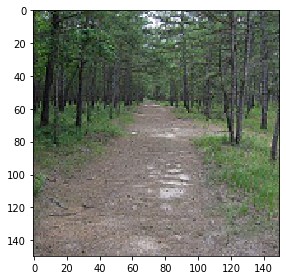

In [ ]:
io.imshow('/content/test_dataset/bosques/20056.jpg')

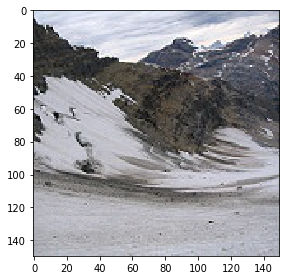

In [ ]:
io.imshow('/content/train_dataset/glaciares/10055.jpg')

Vamos a definir una función que coja todas las imágenes de cada uno de los directorios del conjunto de entrenamiento o test y vamos a insteralas en un array. Nos quedaremos solo con las fotos que tienen 150x150 píxeles, ya que hay algunas que no son de estas dimensiones. También añadimos un parámetro max, de manera que elegimos el máximo de fotos por directorio que guardamos, de manera que tengamos el mismo número de imágenes para cada clase.

In [ ]:
clases = ['bosques', 'calles', 'edificios', 'glaciares', 'mares', 'montanias']
def imagesToArray (dataset_path, clases_path, max):
  j = 0
  images_array = []
  labels = []
  for i in os.listdir(dataset_path): #Recorremos todas las clases
    if j in range(0,len(clases_path)):
      k = 0
      for file in os.listdir(clases_path[j]): #Recorremos todas lás imagenes para cada clase
        if k < max:
          imagen = io.imread(dataset_path + '/' + clases[j] + '/' + file)
          if imagen.shape == (150,150,3): #Desechamos las imágenes que no son de 150x150 píxeles
            datos = np.array(imagen)
            images_array.append(datos.reshape(-1))
            labels.append(j)
            k = k + 1
    j= j+1
  return images_array,labels

Primero creamos el array con los datos de entrenamiento:

In [ ]:
train_clases_path = ['/content/train_dataset/bosques','/content/train_dataset/calles','/content/train_dataset/edificios','/content/train_dataset/glaciares','/content/train_dataset/mares','/content/train_dataset/montanias']
X_train,Y_train = imagesToArray('/content/train_dataset',train_clases_path, 600)

Transformamos los datos a un numpy array para poder trabajar con ellos:

In [ ]:
X_train = np.array(X_train)
X_train

array([[193, 202, 135, ...,   5,   5,   3],
       [162, 194, 215, ...,  23,  33,  42],
       [  0,   0,   0, ...,  78,  78,  78],
       ...,
       [196, 203, 209, ..., 121, 114, 122],
       [146, 146, 154, ..., 210, 136,  51],
       [170, 182, 204, ..., 119,  88,  41]], dtype=uint8)

In [ ]:
print('Número de imágenes en el conjunto de entrenamiento:', len(X_train))

Número de imágenes en el conjunto de entrenamiento: 3600


Vamos a pintar el histograma para ver como se distribuyen los píxeles:

(array([4509210., 1098106.,  978980.,  949065.,  969839.,  951318.,
         950944.,  958367.,  949280.,  953821.,  956735.,  963413.,
         964310.,  973938.,  982254.,  985266.,  996887., 1002870.,
        1012639., 1018136., 1020431., 1027062., 1035081., 1045800.,
        1054662., 1064835., 1068026., 1074045., 1077971., 1081791.,
        1087358., 1091752., 1097008., 1103975., 1104187., 1106664.,
        1112000., 1121413., 1119051., 1124229., 1126189., 1126460.,
        1127694., 1129106., 1130879., 1134898., 1135289., 1137317.,
        1138897., 1136828., 1137540., 1134766., 1135716., 1137701.,
        1135421., 1138794., 1141993., 1142905., 1147461., 1148701.,
        1148603., 1148318., 1149963., 1150049., 1149242., 1144563.,
        1146348., 1144965., 1144446., 1141241., 1141677., 1142452.,
        1139424., 1137126., 1137855., 1140329., 1135675., 1136071.,
        1135817., 1132031., 1130481., 1128469., 1125207., 1125283.,
        1122192., 1121118., 1118606., 1116299., 

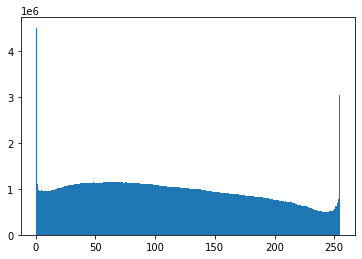

In [ ]:
plt.hist(X_train.ravel(),bins=255)

Ahora creamos el array para los datos de test:

In [ ]:
test_clases_path = ['/content/test_dataset/bosques','/content/test_dataset/calles','/content/test_dataset/edificios','/content/test_dataset/glaciares','/content/test_dataset/mares','/content/test_dataset/montanias']
X_test,Y_test = imagesToArray('/content/test_dataset',test_clases_path, 125)

Igual que hemos hecho con los datos de entrenamiento, transformamos los de test a un numpy array:

In [ ]:
X_test = np.array(X_test)
X_test

array([[244, 244, 244, ..., 170, 167, 162],
       [ 19,  34,   0, ..., 129, 114,  93],
       [110, 108, 109, ...,  30,  40,   6],
       ...,
       [  0, 132, 193, ...,  72,  57,  34],
       [ 39, 117, 156, ...,  37,  39,   0],
       [186, 191, 210, ...,  61,  60,  29]], dtype=uint8)

Vamos a ver cuantas imágenes de 150 x 150 píxeles hay en el dataset

In [ ]:
print('Número de imágenes en el conjunto de test:', len(X_test))

Número de imágenes en el conjunto de test: 750


Vamos a pintar el histograma del conjunto de test también:

(array([911776., 211368., 197787., 191145., 196100., 192090., 191592.,
        196413., 195387., 197700., 198673., 202749., 204207., 207642.,
        209937., 211583., 213759., 213003., 214911., 216071., 217537.,
        218511., 220158., 222368., 222354., 222787., 223756., 226214.,
        228438., 229122., 229218., 228124., 230574., 230226., 231796.,
        232855., 233808., 233015., 234343., 234808., 234276., 235330.,
        235739., 237669., 238900., 237956., 238415., 238833., 238504.,
        239042., 239135., 238631., 238792., 240043., 239361., 239209.,
        238605., 240480., 241154., 240208., 242161., 240923., 241242.,
        240479., 240313., 239953., 239561., 239291., 239165., 239073.,
        238520., 238184., 237208., 235584., 236235., 235174., 234669.,
        233531., 232402., 231104., 229302., 229840., 228868., 227920.,
        227439., 227406., 226281., 226606., 225055., 224039., 223561.,
        223157., 222077., 222416., 222968., 222735., 221336., 220473.,
      

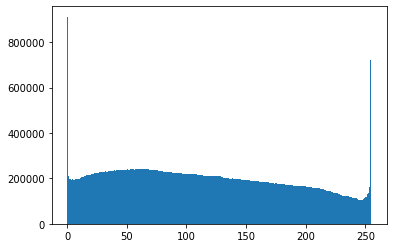

In [ ]:
plt.hist(X_test.ravel(),bins=255)

Ahora tenemos dos arrays, uno de test y otro de train, que contienen las imágenes en forma de vector, por lo que podemos trabajar con ellas.

Vamos a calcular los percentiles máximos y mínimos para utilizarlos, si fuera necesario, al reescalar la intensidad de las imágenes.

In [ ]:
p_min, p_max = np.percentile(X_train, (20, 80))
p_min,p_max

(43.0, 185.0)

Guardaremos en una array las imágenes en completa resolución para posteriormente poder pintarlas.

In [ ]:
X_test_img = X_test.reshape(len(X_test),150,150,3)

A continuación definimos varias funciones que nos permiten preprocesar las imágenes, aplicando diferentes filtros o procesos. Cabe añadir que en el resultado final solo utilizamos "substractCorners" y "resizing".

Debido a que finalmente consideramos que las imágenes a color aportaban más al modelo que las imágenes en blanco y negro, hay determinados filtros que no funcionan sobre nuestro dataset final, debiendo aplicar antes, si se quieren utilizar dichas funciones, el filtro de blanco y negro. Estas son : applySobel,applyMedian. Las dejamos definidas para que se vea su implementación.


In [ ]:
def substractCorners(images):
  image = images[0].reshape(150,150,3)
  nrows = 150
  ncols = 150
  row, col = np.ogrid[:nrows, :ncols]
  cnt_row, cnt_col = nrows / 2, ncols / 2
  outer_disk_mask = ((row - cnt_row)**2 + (col - cnt_col)**2 > (nrows / 2)**2)
  for i in range(0,len(images)):
    image = images[i].reshape(150,150,3)
    image[outer_disk_mask] = 0

In [ ]:
def reescaleIntensity(images, min, max):
  for i in range(0,len(images)):
    images[i] = exposure.rescale_intensity(images[i],in_range=(min,max))

In [ ]:
def applySobel(images):
  for i in range(0,len(images)):
    image = images[i].reshape(150,150)
    image = filters.sobel(images[i].reshape(150,150))
    images[i] = image.reshape(-1)

In [ ]:
def applyMedian(images):
  for i in range(0,len(images)):
    image = images[i].reshape(150,150,3)
    image = filters.median(images[i].reshape(150,150,3))
    images[i] = image.reshape(-1)

In [ ]:
def resizing(images, dim):
  new_images = [None]*len(images)
  for i in range(0,len(images)):
    img = images[i].reshape(150,150,3)
    resized_img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    image = np.array(resized_img)
    new_images[i] = image.reshape(-1)
  return np.array(new_images)

In [ ]:
substractCorners(X_train)
substractCorners(X_test)

In [ ]:
dim = (20,20)
X_train = resizing(X_train,dim)
X_test = resizing(X_test,dim)

In [ ]:
#applySobel(X_train)
#applySobel(X_test)

In [ ]:
#applyMedian(X_train)
#applyMedian(X_test)

In [ ]:
#reescaleIntensity(X_train,p_min,p_max)
#reescaleIntensity(X_test,p_min,p_max)

Ahora mostraremos una imagen aleatoria del dataset de entrenamiento para mostrar el estado final de la fotografia.

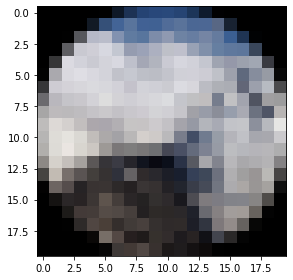

In [ ]:
X_train_img = X_train.reshape(len(X_train),20,20,3)
r = random.randrange(len(X_train))
io.imshow(X_train_img[r])

##Modelos 

###Voting classifier

Para la utilización del voting classifier, utilizaremos tres modelos distintos: Regresión logística, Naive Bayes y svc. Antes de entrenar el ensemble, vamos a optimizar todos los hiperparámetros de cada uno de los submodelos, para luego entrenar el voting classifier.

Empezamos con la regresión logística:

In [ ]:
log_hyperparameters = {
    'max_iter': [1500,2000]
}

In [ ]:
grid_log_clf = GridSearchCV(
    LogisticRegression(random_state=1337, n_jobs=-1),
    log_hyperparameters,
    cv = 5,
    n_jobs = -1
)

In [ ]:
grid_log_clf.fit(X_train,Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=-1, penalty='l2',
                                          random_state=1337, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1, param_grid={'max_iter': [1500, 2000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
grid_log_clf.best_params_

{'max_iter': 1500}

Para el naive bayes no es necesario hacer grid, así que entrenamos el modelo:

In [ ]:
nb_clf = GaussianNB()

In [ ]:
nb_clf.fit(X_train,Y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

Finalmente, el modelo svc:

In [ ]:
svm_hyperparameters = {
    'degree': [2,3],
    'C': [0.01,0.1,1],
    'gamma': ['scale','auto']
}

In [ ]:
grid_svm_clf = GridSearchCV(
    svm.SVC(kernel='rbf'),
    svm_hyperparameters,
    cv = 5,
    n_jobs = -1
)

In [ ]:
grid_svm_clf.fit(X_train,Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1], 'degree': [2, 3],
                         'gamma': ['scale', 'auto']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
grid_svm_clf.best_params_

{'C': 1, 'degree': 2, 'gamma': 'scale'}

Con todos los modelos optimizados, entrenamos el voting classifier:

In [ ]:
voting_clf = VotingClassifier(
    estimators=[('lr', grid_log_clf), ('nb', nb_clf), ('svm', grid_svm_clf)],
    voting='hard')

In [ ]:
voting_clf.fit(X_train,Y_train)

VotingClassifier(estimators=[('lr',
                              GridSearchCV(cv=5, error_score=nan,
                                           estimator=LogisticRegression(C=1.0,
                                                                        class_weight=None,
                                                                        dual=False,
                                                                        fit_intercept=True,
                                                                        intercept_scaling=1,
                                                                        l1_ratio=None,
                                                                        max_iter=100,
                                                                        multi_class='auto',
                                                                        n_jobs=-1,
                                                                        penalty='l2',
                         

In [ ]:
Y_pred = voting_clf.predict(X_test)
print(accuracy_score(Y_test, Y_pred))

0.536


Tenemos un porcentaje de éxito en la predicción de 53,6% en este modelo.

###Bag classifier

Para conseguir el mejor modelo posible de bag classifier, vamos a realizar un grid search para optimizar sus parámetros globales. Como estimador base utilizaremos árboles de decisión de profundidad 3.

In [ ]:
bag_hyperparameters = {
    'n_estimators' : [20,100,500,1000],
    'max_samples' : [10,100,1000],
    'max_features' : [1,2]
}

In [ ]:
grid_bag_clf = GridSearchCV(
    BaggingClassifier(
          base_estimator=DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=3), 
          n_jobs=-1, 
          random_state=1337),
    bag_hyperparameters,
    cv = 5,
    n_jobs = -1
)

In [ ]:
grid_bag_clf.fit(X_train,Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                               class_weight=None,
                                                                               criterion='entropy',
                                                                               max_depth=3,
                                                                               max_features=None,
                                                                               max_leaf_nodes=None,
                                                                               min_impurity_decrease=0.0,
                                                                               min_impurity_split=None,
                                                                               min_samples_leaf=1,
                                                                         

In [ ]:
grid_bag_clf.best_params_

{'max_features': 2, 'max_samples': 1000, 'n_estimators': 1000}

In [ ]:
Y_pred = grid_bag_clf.predict(X_test)
print(accuracy_score(Y_test, Y_pred))

0.45066666666666666


Podemos observar que el modelo acierta el 45,07% de las veces

###AdaBoost

En este modelo, ejecutaremos un grid search buscando el número óptimo de estimadores.

In [ ]:
ada_hyperparameters = {
    'n_estimators' : [10,50,100]
}

In [ ]:
grid_ada_clf = GridSearchCV(
    AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), random_state=1337),
    ada_hyperparameters,
    cv = 5,
    n_jobs = -1
)

In [ ]:
grid_ada_clf.fit(X_train,Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=1,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
    

In [ ]:
grid_ada_clf.best_params_

{'n_estimators': 100}

In [ ]:
Y_pred = grid_ada_clf.predict(X_test)
print(accuracy_score(Y_test, Y_pred))

0.448


Este modelo predice con un 44,8% de acierto.

###Stack Classifier

Para el stack classifier no utilizaremos grid search, ya que los tiempos obtenidos son demasiado grandes y la precisión final no sobrepasa por mucho al resto de modelos. Lo entrenamos utilizando modelos de regresión logística, naive bayes y svm no lineal. Utilizaremos 'passthrough' en false, de manera que los resultados de los submodelos no pasen por el modelo final para reducir los tiempos de entrenamiento.

In [ ]:
log_clf = LogisticRegression(random_state=1337, n_jobs=-1, max_iter = 1500)
nb_clf = GaussianNB()
svm_clf = svm.SVC(kernel='rbf')

In [ ]:
stack_clf = StackingClassifier(
    estimators=[('lr', log_clf), ('nb', nb_clf), ('svm', svm_clf)],
    final_estimator= LogisticRegression(random_state=1337, n_jobs=-1, max_iter=1500),
    passthrough=False)

In [ ]:
stack_clf.fit(X_train,Y_train)

StackingClassifier(cv=None,
                   estimators=[('lr',
                                LogisticRegression(C=1.0, class_weight=None,
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1,
                                                   l1_ratio=None, max_iter=1500,
                                                   multi_class='auto',
                                                   n_jobs=-1, penalty='l2',
                                                   random_state=1337,
                                                   solver='lbfgs', tol=0.0001,
                                                   verbose=0,
                                                   warm_start=False)),
                               ('nb',
                                GaussianNB(priors=None, var_smoothing=1e-09)),
                        

In [ ]:
Y_pred = stack_clf.predict(X_test)
print(accuracy_score(Y_test, Y_pred))

0.5813333333333334


Obtenemos una tasa de acierto del 58,14% en el Stack classifier.

###Random forest classifier

Para el modelo de random forest classifier, también utilizaremos grid search de manera que lo optimizaremos lo máximo posible.

In [ ]:
RF_hyperparameters = {
    'n_estimators': [150,400],
    'max_depth' : [4,8,None],
    'criterion': ['gini', 'entropy']
    }

In [ ]:
grid_rf_clf = GridSearchCV(
    RandomForestClassifier(random_state = 1337, n_jobs = -1),
    RF_hyperparameters,
    cv = 5,
    n_jobs = -1
)

In [ ]:
grid_rf_clf.fit(X_train,Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False,
                                              random_

In [ ]:
grid_rf_clf.best_params_

{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 400}

In [ ]:
Y_pred = grid_rf_clf.predict(X_test)
print(accuracy_score(Y_test, Y_pred))

0.5946666666666667


En este modelo obtenemos el mejor resultado hasta el momento, con un porcentaje de acierto de 59,47%.

##Resultado final

Comparando las precisiones de los diferentes modelos, vemos que el modelo que mejor funciona en nuestro caso es el Random Forest Classifier, con una tasa de acierto del 59,47%. Por lo tanto, este es el modelo que proponemos como solución, y pasaremos a analizarlo.

Primero nos aseguramos de que tenemos guardadas las predicciones del modelo solución propuesto:

In [ ]:
Y_pred = grid_rf_clf.predict(X_test)

Vamos a dibujar la matriz de confusión para analizar el modelo y poder ver las clases en las que más acierta y en las que menos, y qué clases son las que más confunde.

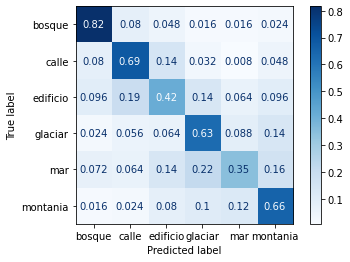

In [ ]:
label_names = ['bosque','calle','edificio','glaciar','mar','montania']
scaler = preprocessing.StandardScaler().fit(X_train)
RF_clf.fit(scaler.transform(X_train),Y_train)
plot_confusion_matrix(RF_clf, scaler.transform(X_test), Y_test, display_labels=label_names, normalize='true', cmap='Blues')

Según la matriz, el 82% de las imágenes de bosques son clasificadas correctamente, y no las confunde con ninguna clase específicamente. 

En el caso de las imágenes de calles, el 69% se clasifican como tal, aunque podemos ver que el 14% se clasifican como edificios. Esto es lógico, ya que la mayoría de las imágenes de calles tienen edificios y el modelo puede confundirlas con mayor frecuencia.

El 42% de las imágenes de edificios se clasifican correctamente, siendo el 19% clasificadas como calles por la razón descrita anteriormente. También confunde el 14% por glaciares.

En cuanto a los glaciares, el modelo acierta en el 63% de los casos, confundiendo un 14% por montañas. Esto probablemente se debe a que las montañas y los glaciares siguen una distribución similar en sus fotos. Además, se puede observar en las imágenes de la clase "montania" que muchas de las montañas están nevadas, lo que puede llevar a que el modelo las confunda por glaciares y viceversa.

La tasa de acierto en la predicción de las imágenes de mares es del 35%, la más baja de todas. El 22% las confunde por glaciares, probablemente porque muchas de estas imágenes tienen pequeños lagos o trozos de mar. Otro 14% lo confunde por edificios, ya que en un número considerable de imágenes de mares hay edificios también.

Por último, el modelo clasifica correctamente el 66% de las imágenes de montañas, confundiendo el 10% por glaciares por razones descritas con anterioridad, y el 12% por mares ya que en algunas de estas fotos también tenemos pequeños espacios con agua.

Vamos a definir una función que escriba 10 predicciones de imágenes aleatorias, junto con las imágenes que se están prediciendo para ver cómo funciona nuestro modelo sobre el conjunto de test.

In [ ]:
def predictRandomImages():
  plt.figure(figsize=(30,20))
  columns = 4
  rango = 10
  argumento = ''

  for i in range (rango):
    r = random.randrange(len(X_test))
    argumento = ('Categoria: ' +  clases[Y_test[r]] + ', Predicción: ' + clases[Y_pred[r]])

    ax = plt.subplot(rango / columns + 1, columns, i + 1)
    plt.imshow(X_test_img[r])
    ax.set_title(argumento, fontdict = {'fontsize': 16}, bbox = {'facecolor': 'white'}, loc = 'center')

La función puede ejecutarse el número de veces que se quiera, para ver su funcionamiento.

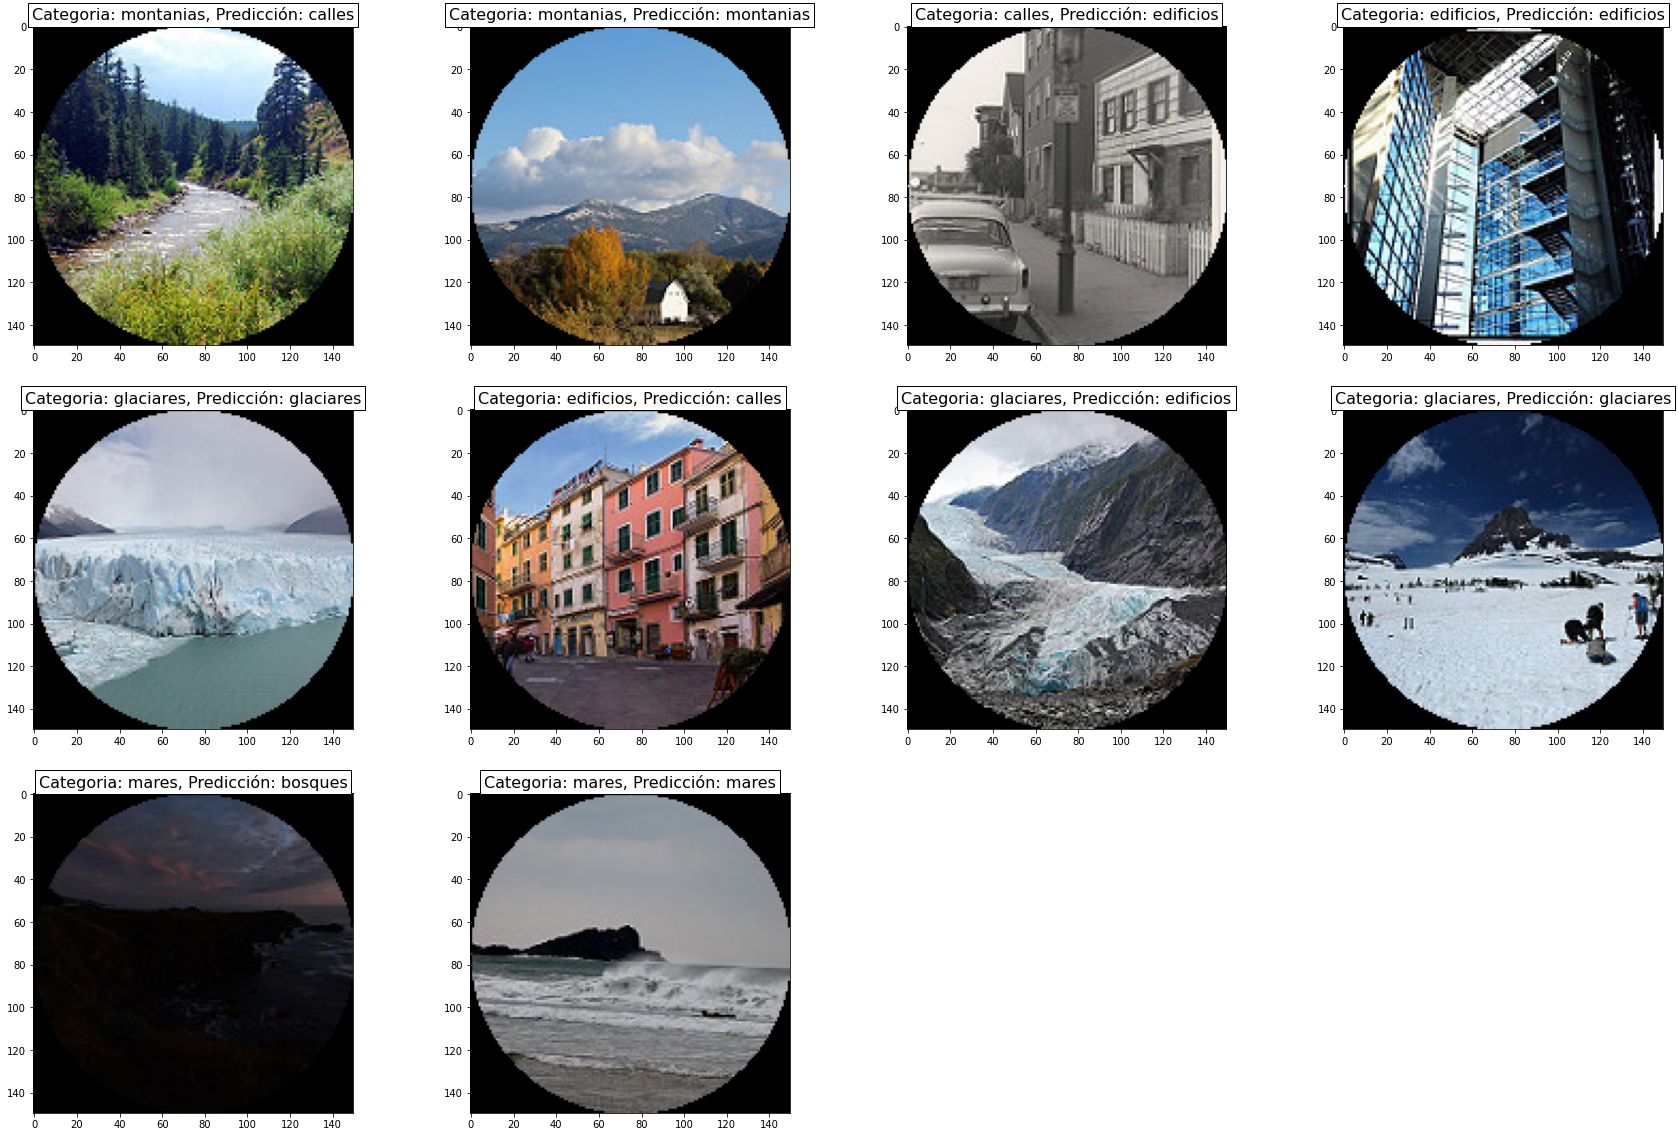

In [ ]:
predictRandomImages()

Vamos a pintar una imágen en concreto, para explicar alguno de los casos en los que falla el modelo:

Text(0.5, 1.0, 'Categoria: montanias, Predicción: glaciares')

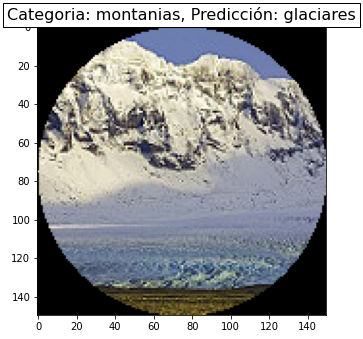

In [ ]:
plt.figure(figsize=(30,20))
argumento = ('Categoria: ' +  clases[Y_test[698]] + ', Predicción: ' + clases[Y_pred[698]])
ax = plt.subplot(rango / columns + 1, columns, i + 1)
plt.imshow(X_test_img[698])
ax.set_title(argumento, fontdict = {'fontsize': 16}, bbox = {'facecolor': 'white'}, loc = 'center')

Como podemos observar, la imagen pertenece a la categoría de montañas, y el modelo la predice como glaciar. Esto es muy probablemente por los colores y la disposición de la imagen, ya que las montañas y los glaciares pueden ser similares en cuanto a forma y en este caso específico las montañas están nevadas, así que también se asimilan en color.

##Conclusiones

Hemos podido observar que el dataset del que partíamos tenía un número considerable de clases (6), y la manera en la que se nos proporcionaba nos complicó preprocesar los datos, teniendo que descomprimir los ficheros y, posteriormente, añadiéndolos a mano a sus respectivos conjuntos de entrenamiento y test. 

También vimos que muchas de las imágenes eran confusas y no se asimilaban a las imágenes de la clase a la que pertenecían. Algunas de estas imágenes no tenían las dimensiones especificadas (150x150 píxeles), así que tuvimos que tenerlo en cuenta para coger datos con los que pudiésemos trabajar. Cabe mencionar que el dataset era muy grande, (14000 imágenes de train y 3000 de test), así que tuvimos que quedarnos con un porcentaje (siendo proporcional para cada clase) para poder entrenar y optimizar los modelos de manera más eficiente.

En cuanto a los modelos, hemos podido observar que los modelos de ensemble son muy útiles, al utilizar otros modelos y comparando, ya que nos permite obtener buenos modelos sin demasiada carga computacional. El grid search para la optimización, tanto de cada uno de los ensembles como sus submodelos, nos es útil para obtener precisiones mejores.

Para terminar, siendo todos los modelos que hemos entrenado similares en cuanto a precisión (variando en torno al 5-10%), es muy difícil que estos superen al modelo de Random Forest Classifier, ya que en la mayoría de casos éste es el que mejor resultados proporciona.